### 问题建模

In [1]:
import time
import warnings
warnings.filterwarnings('ignore') # 忽略警告提示

import numpy as np
import pandas as pd
import tsfresh as tsf

import scipy.stats as st
from math import sqrt

import lightgbm as lgb
import xgboost as xgb

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import colors 
from matplotlib.ticker import PercentFormatter 

from sklearn.model_selection import KFold,cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error,precision_score,recall_score,f1_score
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV,Lasso
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor


In [2]:
# 构建一个计算准确率、召回率和F1-score的评价代码
y_train = np.array([1,0,1,0,1,0,1,0,1,1])
y_pred = np.array([1,1,1,1,0,0,0,0,1,0])
precision = precision_score(y_train,y_pred) #准确率
recall = recall_score(y_train,y_pred) #召回率
f1 = f1_score(y_train,y_pred) #f1度量
print(precision,recall,f1)

0.6 0.5 0.5454545454545454


In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [5]:
all_data = pd.concat((train,test))
all_data = pd.get_dummies(all_data) # 将所有非数值变量均变成哑变量（即onehot形式）
# 填充缺失值
all_data = all_data.fillna(all_data.mean())
# 数据切分
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [6]:
params = {'num_leaves': 63,
          'min_child_samples': 50,
          'objective': 'regression',
          'learning_rate': 0.01,
          'boosting_type': 'gbdt',
          'metric': 'rmse',
          'verbose': -1,
         } 
folds = KFold(n_splits=5, shuffle=True, random_state=2020)
print(folds)
for trn_idx, val_idx in folds.split(X_train, y):
    trn_df, trn_label = X_train.iloc[trn_idx, :], y[trn_idx]
    val_df, val_label = X_train.iloc[val_idx, :], y[val_idx]
    dtrn = lgb.Dataset(trn_df, label = trn_label)
    dval = lgb.Dataset(val_df, label = val_label) 
    bst = lgb.train(params,dtrn, 
                    num_boost_round=1000,
                    valid_sets=[dtrn, dval],
                    early_stopping_rounds=100, verbose_eval=100)

KFold(n_splits=5, random_state=2020, shuffle=True)
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 34583.7	valid_1's rmse: 33466.3
[200]	training's rmse: 22770.9	valid_1's rmse: 18964.6
[300]	training's rmse: 19899.1	valid_1's rmse: 16299.2
[400]	training's rmse: 18740.3	valid_1's rmse: 15997.4
Early stopping, best iteration is:
[397]	training's rmse: 18766.3	valid_1's rmse: 15991.7
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 34408.6	valid_1's rmse: 33487
[200]	training's rmse: 21861.1	valid_1's rmse: 20431.9
[300]	training's rmse: 19073.3	valid_1's rmse: 17497.6
[400]	training's rmse: 18061.7	valid_1's rmse: 16475.3
[500]	training's rmse: 17425.2	valid_1's rmse: 15887.5
[600]	training's rmse: 16919	valid_1's rmse: 15448.9
[700]	training's rmse: 16482.9	valid_1's rmse: 15124.6
[800]	training's rmse: 16052.4	valid_1's rmse: 14837.6
[900]	training's rmse: 15635.8	valid_1's rmse: 14584.8
[1000]	training's rmse: 

### 结果分析

In [7]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)
model_ridge = Ridge()

In [8]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

Text(0, 0.5, 'rmse')

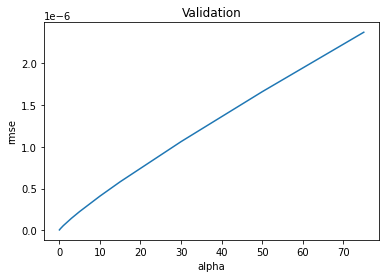

In [9]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [10]:
cv_ridge.min()

4.047404508915239e-09

In [11]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
rmse_cv(model_lasso).mean()

524.7581840311993

In [12]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 269 variables and eliminated the other 21 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

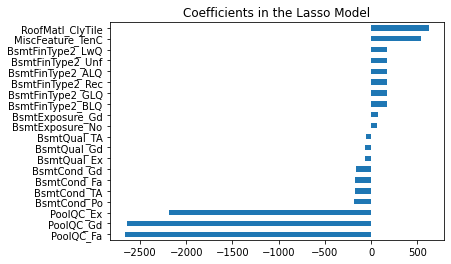

In [13]:
imp_coef = pd.concat([coef.sort_values().head(10),coef.sort_values().tail(10)])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

<AxesSubplot:xlabel='preds', ylabel='residuals'>

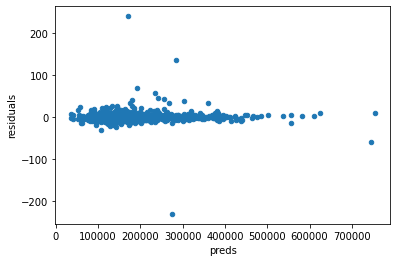

In [14]:
# 接下来观察真实结果与预测结果的残差
preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [15]:
train = pd.concat([train,preds], axis=1)

In [16]:

x = [1,2,4,8]
ts = pd.Series(x)  #数据x假设已经获取
ae = tsf.feature_extraction.feature_calculators.absolute_sum_of_changes(ts)

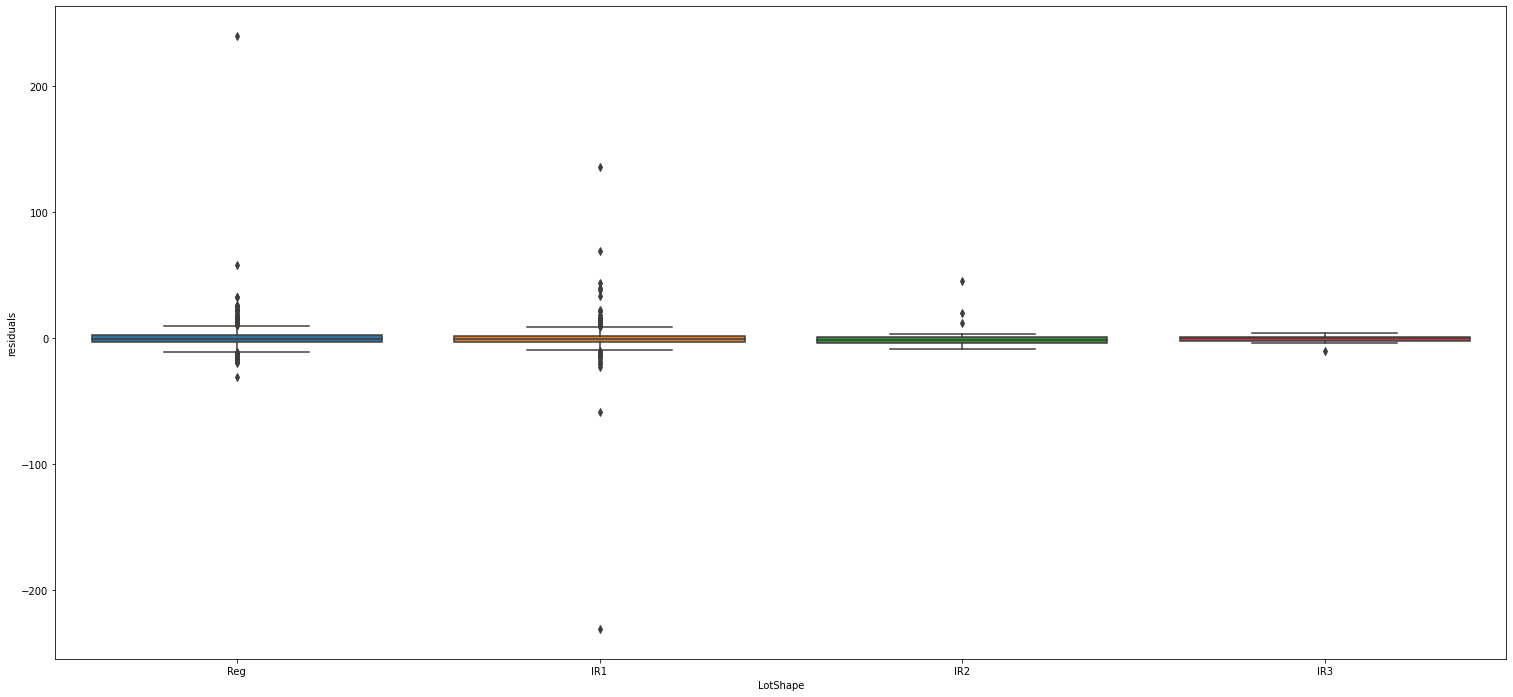

In [17]:
import seaborn as sns

var = 'LotShape'
data = pd.concat([train['residuals'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(26, 12))
fig = sns.boxplot(x=var, y="residuals", data=data)
#fig.axis(ymin=0, ymax=15);

[19:28:41] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:28:42] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:28:42] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

<AxesSubplot:>

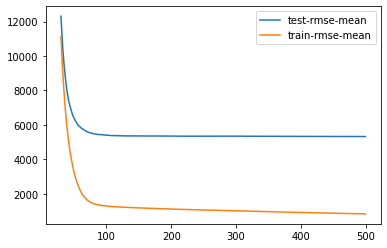

In [18]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1, 'silent': True}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

### 数据探索

In [19]:
stats = []
for col in train.columns:
    stats.append((col, train[col].nunique(), train[col].isnull().sum() * 100 / train.shape[0], train[col].value_counts(normalize=True, dropna=False).values[0] * 100, train[col].dtype))
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)[:10]

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
72,PoolQC,3,99.520548,99.520548,object
74,MiscFeature,4,96.301370,96.301370,object
6,Alley,2,93.767123,93.767123,object
73,Fence,4,80.753425,80.753425,object
57,FireplaceQu,5,47.260274,47.260274,object
3,LotFrontage,110,17.739726,17.739726,float64
63,GarageQual,5,5.547945,89.794521,object
58,GarageType,6,5.547945,59.589041,object
60,GarageFinish,3,5.547945,41.438356,object
64,GarageCond,5,5.547945,90.821918,object


<AxesSubplot:>

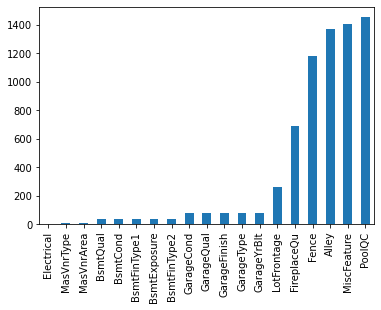

In [20]:
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [21]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

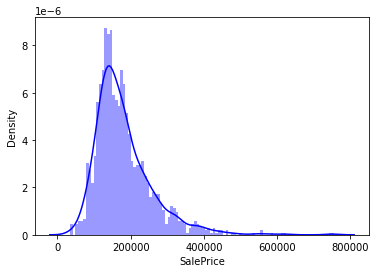

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

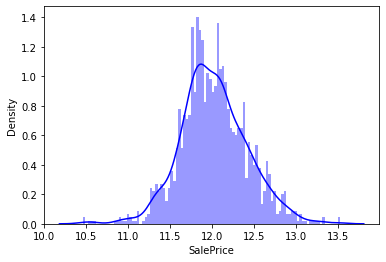

In [22]:
sns.distplot(train['SalePrice'], color='b', bins=100, hist_kws={'alpha': 0.4})
plt.show()
sns.distplot(np.log(train['SalePrice']), color='b', bins=100, hist_kws={'alpha': 0.4})

array([[<AxesSubplot:title={'center':'Id'}>,
        <AxesSubplot:title={'center':'MSSubClass'}>,
        <AxesSubplot:title={'center':'LotFrontage'}>,
        <AxesSubplot:title={'center':'LotArea'}>,
        <AxesSubplot:title={'center':'OverallQual'}>,
        <AxesSubplot:title={'center':'OverallCond'}>],
       [<AxesSubplot:title={'center':'YearBuilt'}>,
        <AxesSubplot:title={'center':'YearRemodAdd'}>,
        <AxesSubplot:title={'center':'MasVnrArea'}>,
        <AxesSubplot:title={'center':'BsmtFinSF1'}>,
        <AxesSubplot:title={'center':'BsmtFinSF2'}>,
        <AxesSubplot:title={'center':'BsmtUnfSF'}>],
       [<AxesSubplot:title={'center':'TotalBsmtSF'}>,
        <AxesSubplot:title={'center':'1stFlrSF'}>,
        <AxesSubplot:title={'center':'2ndFlrSF'}>,
        <AxesSubplot:title={'center':'LowQualFinSF'}>,
        <AxesSubplot:title={'center':'GrLivArea'}>,
        <AxesSubplot:title={'center':'BsmtFullBath'}>],
       [<AxesSubplot:title={'center':'BsmtHalfBath'

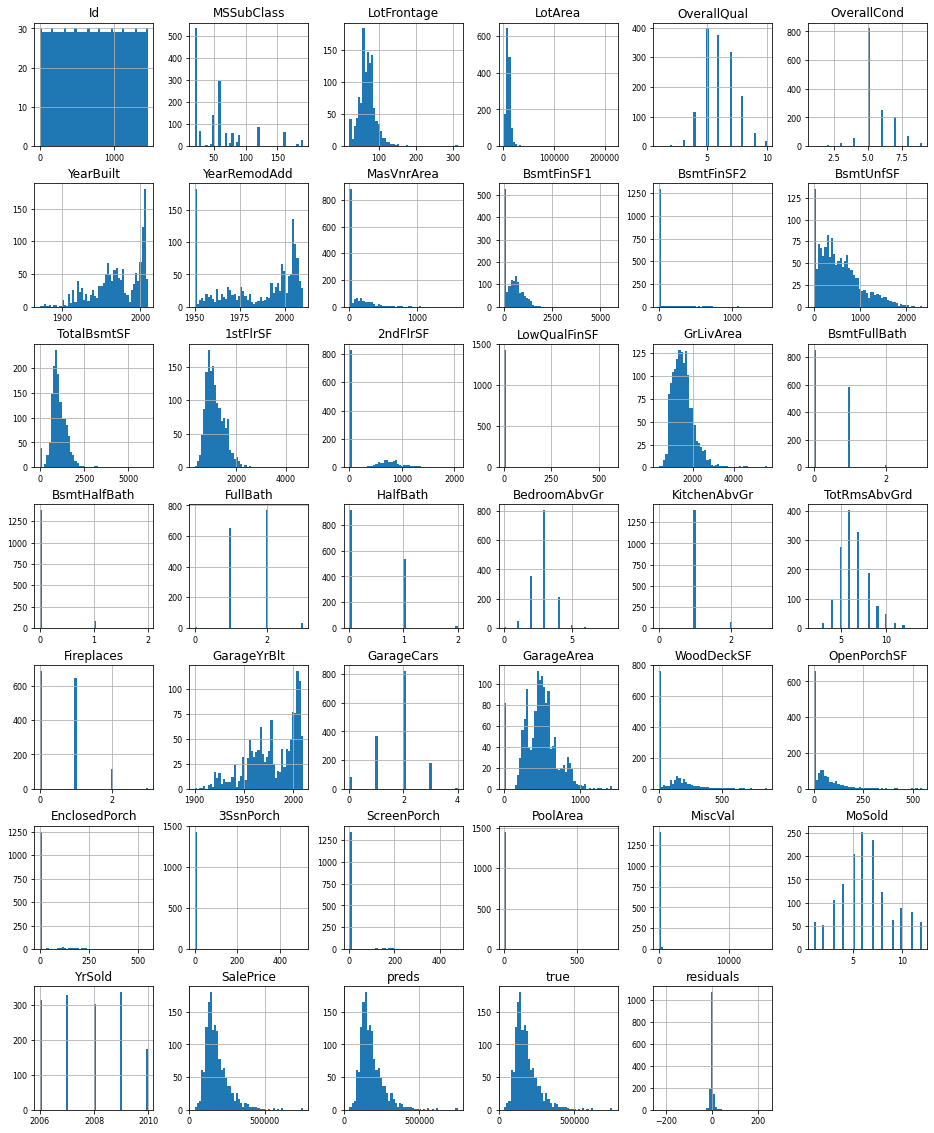

In [23]:
df_num = train.select_dtypes(include = ['float64', 'int64'])
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

<AxesSubplot:>

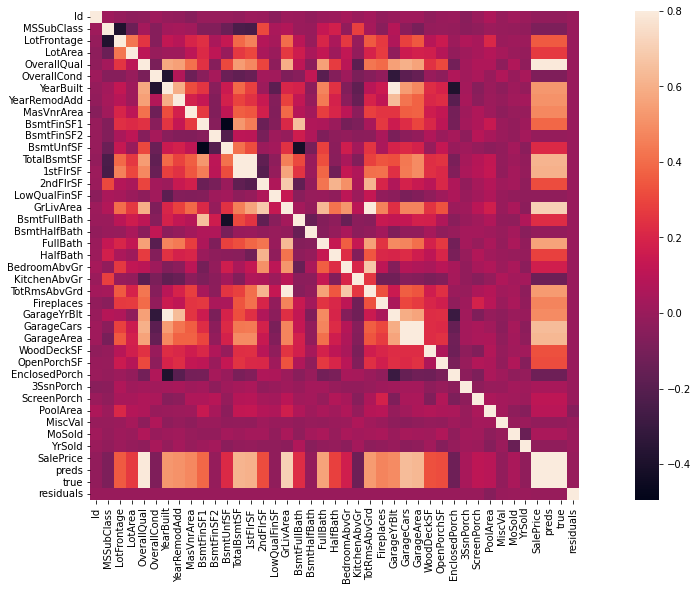

In [24]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corrmat, vmax=0.8, square=True)

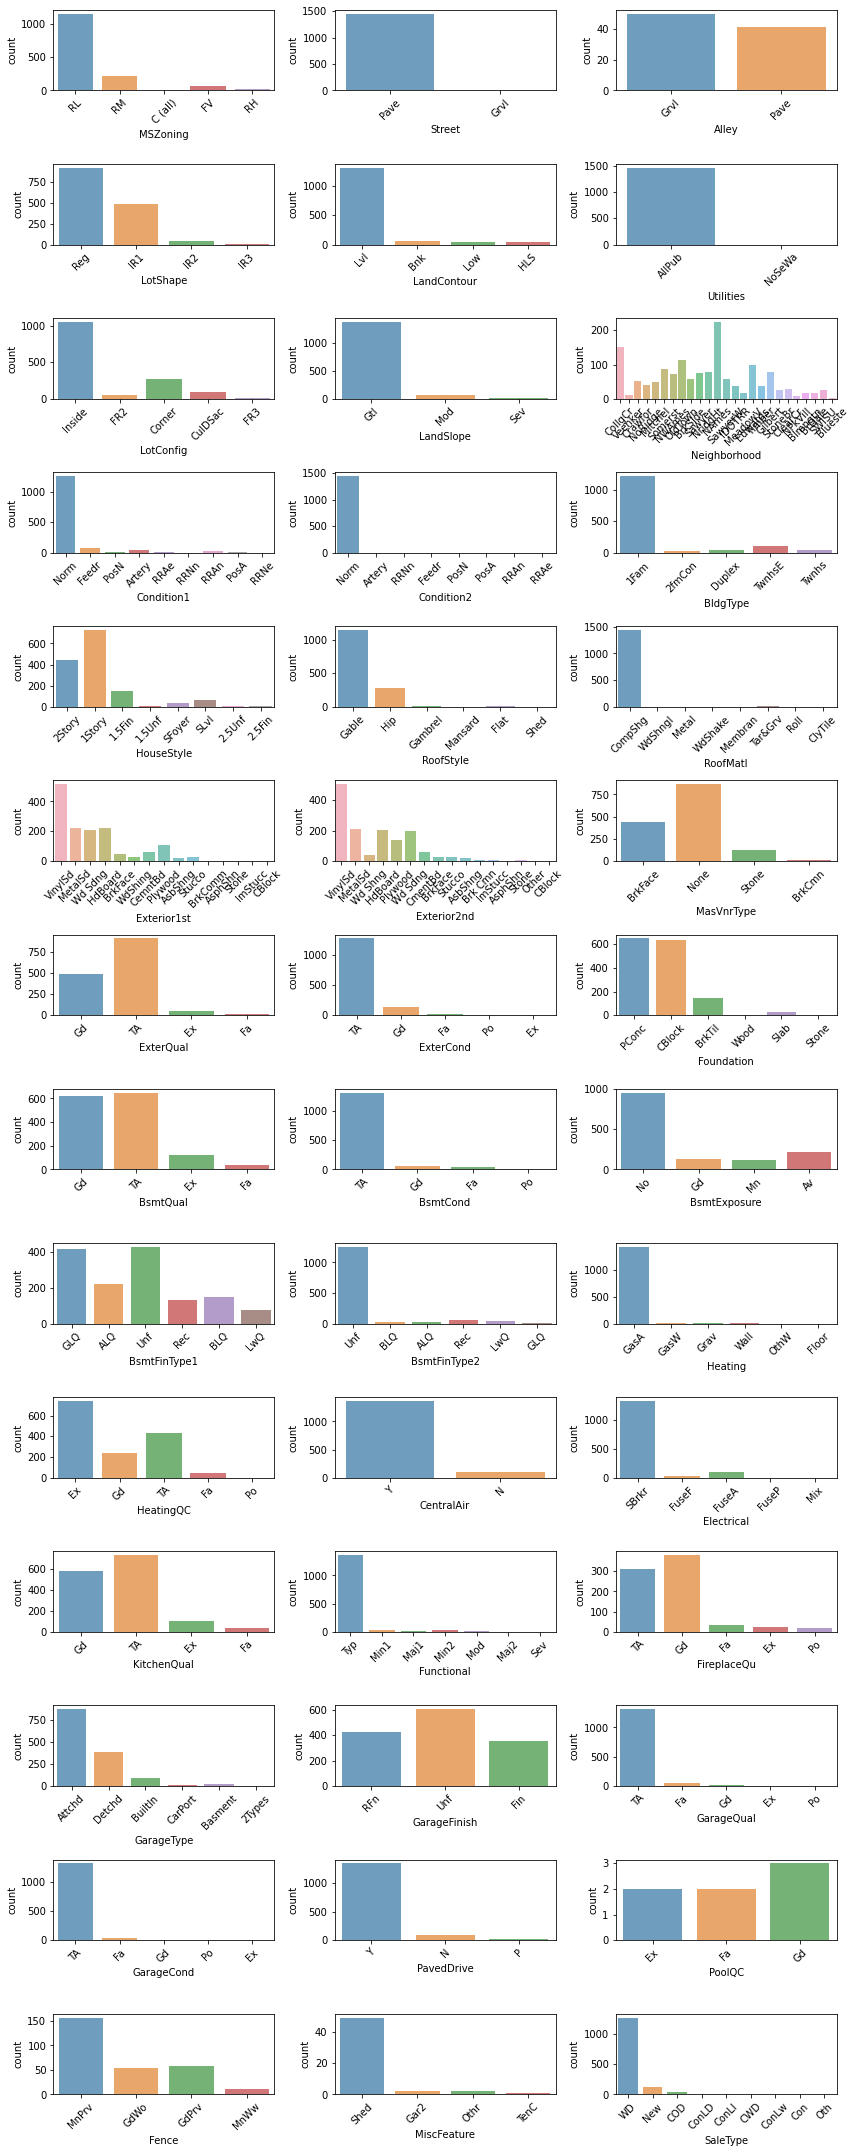

In [25]:
df_not_num = train.select_dtypes(include = ['O'])
fig, axes = plt.subplots(round(len(df_not_num.columns) / 3), 3, figsize=(12, 30))
for i, ax in enumerate(fig.axes):
    if i < len(df_not_num.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=df_not_num.columns[i], alpha=0.7, data=df_not_num, ax=ax)
fig.tight_layout()

array([[<AxesSubplot:title={'center':'MSSubClass'}>,
        <AxesSubplot:title={'center':'LotFrontage'}>],
       [<AxesSubplot:title={'center':'LotArea'}>,
        <AxesSubplot:title={'center':'OverallQual'}>]], dtype=object)

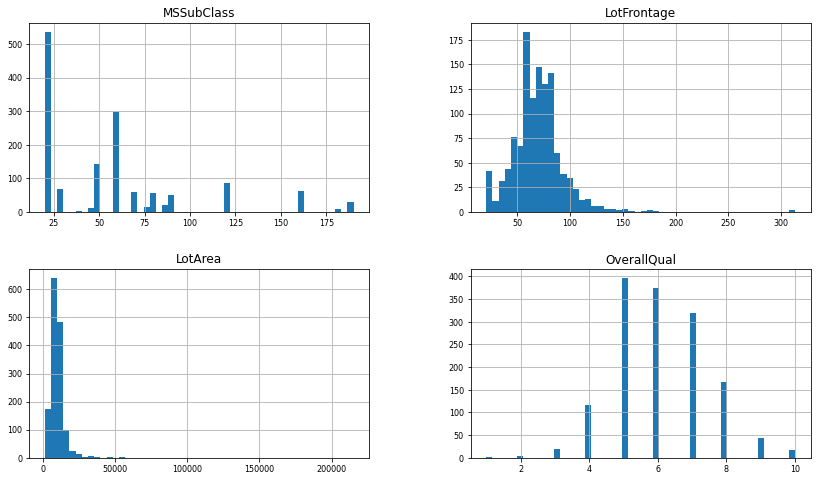

In [26]:
df_num = train.select_dtypes(include = ['float64', 'int64'])
df_num = df_num[df_num.columns.tolist()[1:5]]
df_num.hist(figsize=(14, 8), bins=50, xlabelsize=8, ylabelsize=8)

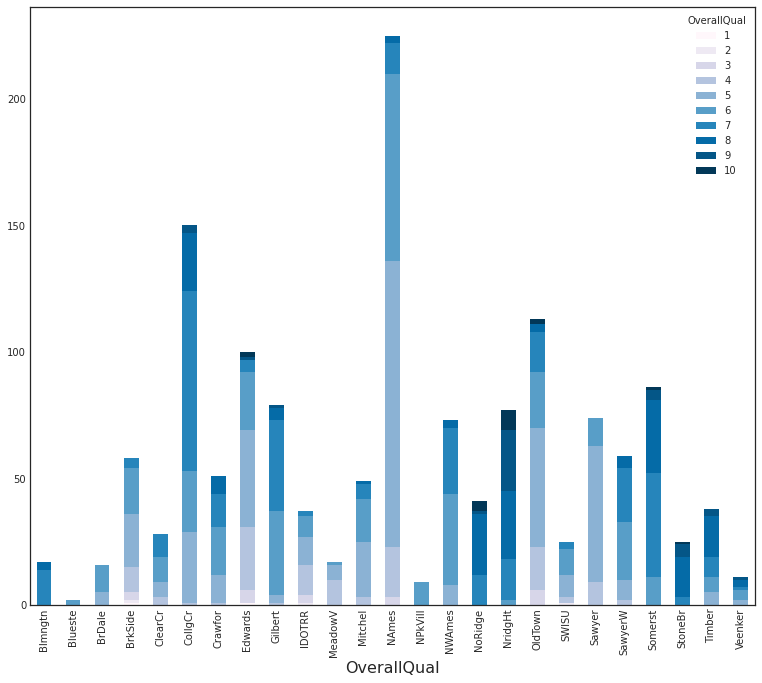

In [27]:
plt.style.use('seaborn-white')
type_cluster = train.groupby(['Neighborhood','OverallQual']).size()
type_cluster.unstack().plot(kind='bar',stacked=True, colormap= 'PuBu', figsize=(13,11),  grid=False)
plt.xlabel('OverallQual', fontsize=16)
plt.show()

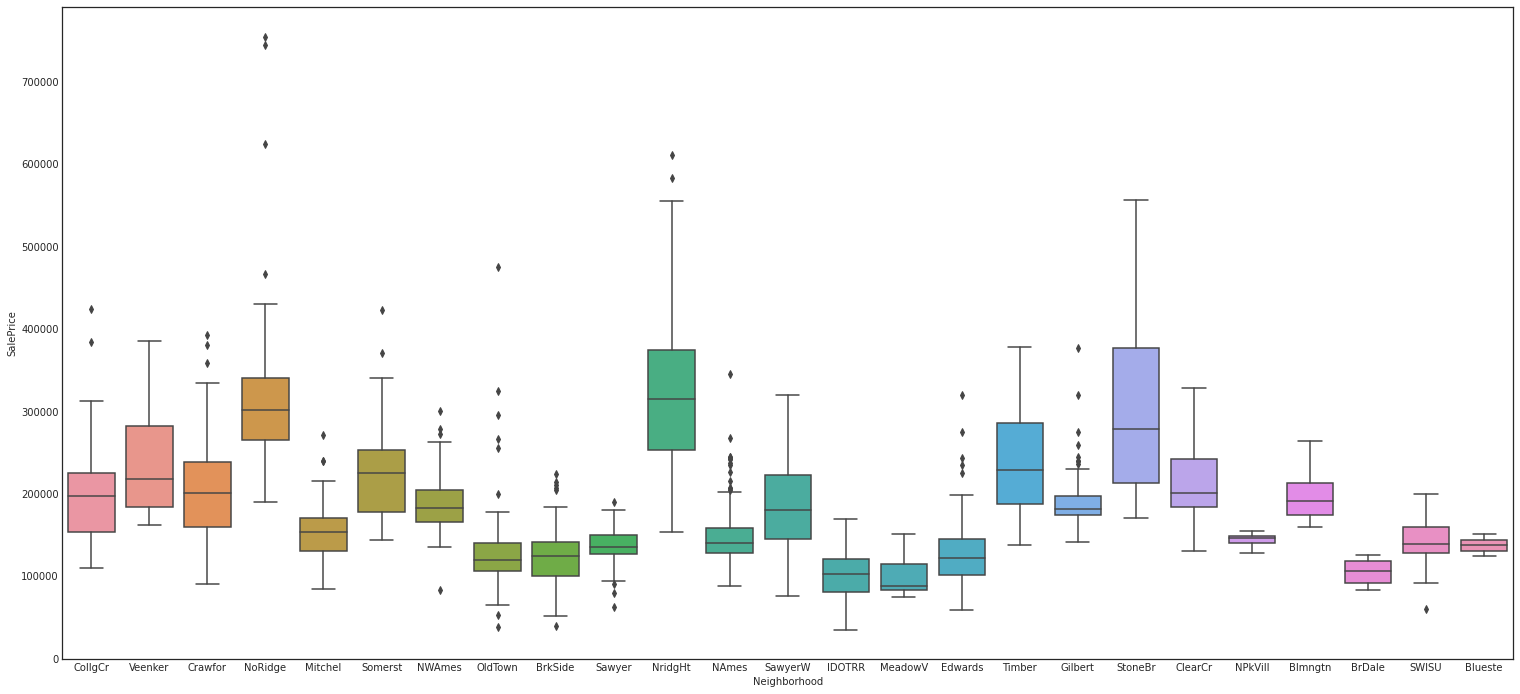

In [28]:
var = 'Neighborhood'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(26, 12))
fig = sns.boxplot(x=var, y="SalePrice", data=data)

### 特征工程

In [29]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
ntrain = train.shape[0]
ntest = test.shape[0]
 
data = pd.concat([train, test], axis=0, sort=False)
# 删除缺失值比例大于50%的特征列
missing_cols = [c for c in data if data[c].isna().mean()*100 > 50]
data = data.drop(missing_cols, axis=1)
 
# 对object型的缺失特征进行填充
object_df = data.select_dtypes(include=['object'])
numerical_df = data.select_dtypes(exclude=['object'])
 
object_df = object_df.fillna('unknow')

In [30]:
# 对数值型特征使用中位数进行填充
missing_cols = [c for c in numerical_df if numerical_df[c].isna().sum() > 0]
for c in missing_cols:
    numerical_df[c] = numerical_df[c].fillna(numerical_df[c].median())

In [31]:
object_df = object_df.drop(['Heating','RoofMatl','Condition2','Street','Utilities'],axis=1)

In [32]:
# 日期先后顺序不一致的数据修改
numerical_df.loc[numerical_df['YrSold'] < numerical_df['YearBuilt'], 'YrSold' ] = 2009
numerical_df['Age_House']= (numerical_df['YrSold'] - numerical_df['YearBuilt'])

In [33]:
# 业务相关特征汇总
numerical_df['TotalBsmtBath'] = numerical_df['BsmtFullBath'] +numerical_df['BsmtHalfBath']*0.5
numerical_df['TotalBath'] = numerical_df['FullBath'] + numerical_df['HalfBath']*0.5 
numerical_df['TotalSA'] = numerical_df['TotalBsmtSF'] + numerical_df['1stFlrSF'] +\
numerical_df['2ndFlrSF']

In [34]:
# 特征编码
bin_map  = {'TA':2,'Gd':3, 'Fa':1,'Ex':4,'Po':1,'None':0,
'Y':1,'N':0,'Reg':3,'IR1':2,'IR2':1, \
'IR3':0,"None" : 0,"No" : 2, "Mn" : 2, 
"Av": 3,"Gd" : 4,"Unf" : 1, "LwQ": 2, \
"Rec" : 3,"BLQ" : 4, "ALQ" : 5, "GLQ" : 6}
object_df['ExterQual'] = object_df['ExterQual'].map(bin_map)
object_df['ExterCond'] = object_df['ExterCond'].map(bin_map)
object_df['BsmtCond'] = object_df['BsmtCond'].map(bin_map)
object_df['BsmtQual'] = object_df['BsmtQual'].map(bin_map)
object_df['HeatingQC'] = object_df['HeatingQC'].map(bin_map)
object_df['KitchenQual'] = object_df['KitchenQual'].map(bin_map)
object_df['FireplaceQu'] = object_df['FireplaceQu'].map(bin_map)
object_df['GarageQual'] = object_df['GarageQual'].map(bin_map)
object_df['GarageCond'] = object_df['GarageCond'].map(bin_map)
object_df['CentralAir'] = object_df['CentralAir'].map(bin_map)
object_df['LotShape'] = object_df['LotShape'].map(bin_map)
object_df['BsmtExposure'] = object_df['BsmtExposure'].map(bin_map)
object_df['BsmtFinType1'] = object_df['BsmtFinType1'].map(bin_map)
object_df['BsmtFinType2'] = object_df['BsmtFinType2'].map(bin_map)
 
PavedDrive = {"N" : 0, "P" : 1, "Y" : 2}

In [35]:
object_df['PavedDrive'] = object_df['PavedDrive'].map(PavedDrive)
# 选择剩余的object特征
rest_object_columns = object_df.select_dtypes(include = ['object'])
# 进行one-hot编码
object_df = pd.get_dummies(object_df, columns = rest_object_columns.columns) 
 
data = pd.concat([object_df, numerical_df], axis=1, sort=False)

#### 特征选择

In [36]:
def correlation(data, threshold):
    col_corr = set() 
    corr_matrix = data.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:  # 相似性分数与阈值对比
                colname = corr_matrix.columns[i]  # 获取列名
                col_corr.add(colname)
    return col_corr

In [37]:
all_cols = [c for c in data.columns if c not in ['SalePrice']]
corr_features = correlation(data[all_cols], 0.9)

### 模型融合

In [38]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

all_data = pd.concat((train,test))
all_data = pd.get_dummies(all_data)
# 填充缺失值
all_data = all_data.fillna(all_data.mean())
# 数据切分
x_train = all_data[:train.shape[0]]
x_test = all_data[train.shape[0]:]
y_train = train.SalePrice

In [39]:
# 依然采用5折交叉验证 
kf = KFold(n_splits=5, shuffle=True, random_state=2020)                                                                                                                                                                                                                                   

class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

def get_oof(clf):
    oof_train = np.zeros((x_train.shape[0],))
    oof_test = np.zeros((x_test.shape[0],))
    oof_test_skf = np.empty((5, x_test.shape[0]))

    scores  = []
    
    for i, (train_index, valid_index) in enumerate(kf.split(x_train, y_train)):
        trn_x, trn_y, val_x, val_y = x_train.iloc[train_index], y_train[train_index],\
            x_train.iloc[valid_index], y_train[valid_index]
        clf.train(trn_x, trn_y)

        oof_train[valid_index] = clf.predict(val_x)
        oof_test_skf[i, :] = clf.predict(x_test)

        scores.append(sqrt(mean_squared_error(val_y, oof_train[valid_index])))

    oof_test[:] = oof_test_skf.mean(axis=0)
    print(np.mean(scores))
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [40]:
et_params = {
   'n_estimators': 100,
    'max_features': 0.5,
    'max_depth': 12,
    'min_samples_leaf': 2,
}
rf_params = {
    'n_estimators': 100,
    'max_features': 0.2,
    'max_depth': 12,
    'min_samples_leaf': 2,
}
rd_params={'alpha': 10}
ls_params={ 'alpha': 0.005}
et = SklearnWrapper(clf=ExtraTreesRegressor, seed=2020, params=et_params)
rf = SklearnWrapper(clf=RandomForestRegressor, seed=2020, params=rf_params)
rd = SklearnWrapper(clf=Ridge, seed=2020, params=rd_params)
ls = SklearnWrapper(clf=Lasso, seed=2020, params=ls_params)

et_oof_train, et_oof_test = get_oof(et)
rf_oof_train, rf_oof_test = get_oof(rf)
rd_oof_train, rd_oof_test = get_oof(rd)
ls_oof_train, ls_oof_test = get_oof(ls)

12273.777563550315
17232.460895702447
4.3574589107847246e-07
349.17978414062225


In [41]:
def stack_model(oof_1, oof_2, oof_3, oof_4, predictions_1, predictions_2, predictions_3, predictions_4, y):
    train_stack = np.hstack([oof_1, oof_2, oof_3, oof_4])
    test_stack = np.hstack([predictions_1, predictions_2, predictions_3, predictions_4])
    
    oof = np.zeros((train_stack.shape[0],))
    predictions = np.zeros((test_stack.shape[0],))
    scores = []

    for fold_, (trn_idx, val_idx) in enumerate(kf.split(train_stack, y)): 
        trn_data, trn_y = train_stack[trn_idx], y[trn_idx]
        val_data, val_y = train_stack[val_idx], y[val_idx]
        
        clf = Ridge(random_state=2020)
        clf.fit(trn_data, trn_y)

        oof[val_idx] = clf.predict(val_data)
        predictions += clf.predict(test_stack) / 5
        
        score_single = sqrt(mean_squared_error(val_y, oof[val_idx]))
        scores.append(score_single)
        print(f'{fold_+1}/{5}', score_single)
    print('mean: ',np.mean(scores))
   
    return oof, predictions

oof_stack , predictions_stack  = stack_model(et_oof_train, rf_oof_train, rd_oof_train, ls_oof_train, et_oof_test, rf_oof_test, rd_oof_test,ls_oof_test, y_train)

1/5 2.6532774194782623e-07
2/5 5.282703996771267e-07
3/5 2.5293081112111894e-07
4/5 9.557751273232116e-05
5/5 4.003457174546628e-07
mean:  1.9404877480504378e-05
